In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
import random
import pickle
from sklearn.preprocessing import StandardScaler
import os
import tensorflow as tf
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

2023-07-23 11:04:14.986156: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-23 11:04:15.032995: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-23 11:04:15.265056: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-23 11:04:15.267115: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-23 11:04:16.708677: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# with open("..//Data//DeepCDR_DualGCN_combo_run_plot.pickle", "rb") as f: 
#     catch = pickle.load(f)


# # In[ ]:


# all_metrics = []
# all_weights = []
# for i in range(0,50):
#     item = catch[i]
#     metrics = item[:7]
#     weights = item[-8:-4]
#     all_metrics.append(metrics)
#     all_weights.append(weights)

In [3]:

# all_metrics_df = pd.DataFrame(all_metrics)


# # In[ ]:


# all_weights_df = pd.DataFrame(all_weights)


# # In[ ]:


# all_df = pd.concat([all_metrics_df, all_weights_df], axis = 1)


# # In[ ]:


# all_df.columns = ['train_width', 'coverage_train', 'rmse_train', 'test_width', 'coverage_test', 'rmse_test', 'pearson_r', 
#                    "DeepCDR_Drugs", "DeepCDR_Omics", "DualGCN_Drugs", "DualGCN_Omics"]




In [4]:
# # In[ ]:


# all_df.head()


In [5]:


# # In[ ]:


# all_df.mean()


In [6]:


# # In[ ]:


# all_df.std()

In [7]:
warnings.filterwarnings('ignore')

In [8]:
# len(weights_ann_1[0].ravel())

In [9]:
def get_targets_with_weights(batch_data, initial_ensembles, size_ens): 
    
    target_dim = 1
    
    # weights_ann_1 = ann.get_weights()
    
    # h1  = ann.layers[1].output.shape[-1]

    n_hidden_1 = len(weights_ann_1[0].ravel())
    
    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)
    
    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)


    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, target_dim)


    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + target_dim)].reshape(size_ens, 1, target_dim)


    final_output_1 = output_1 + output_layer_bias_1
    
    final_output_1 = final_output_1[:,:, 0]
    
    # print(final_output_1.shape, initial_ensembles.shape)
    
    stack = np.hstack((final_output_1, initial_ensembles))

    
    return final_output_1, stack

In [10]:
def ann(hidden = 32, input_shape = 256, output_shape = 1): 
    input_layer = tf.keras.layers.Input(shape = (input_shape))
    hidden_layer = tf.keras.layers.Dense(hidden)
    hidden_output = hidden_layer(input_layer)
    pred_layer = tf.keras.layers.Dense(output_shape, activation = "relu")
    pred_output = pred_layer(hidden_output)
#     pred_output = tf.keras.layers.Activation("softmax")(pred_output)
    model = tf.keras.models.Model(input_layer, pred_output)
    return model

In [11]:
def generate_initial_ensembles(num_weights, lambda1, size_ens):
    mean_vec = np.zeros((num_weights,))
    cov_matrix = lambda1*np.identity(num_weights)
    mvn_samp = mvn(mean_vec, cov_matrix)
    return mvn_samp.rvs(size_ens)

In [12]:
def expit(x):
    """Compute softmax values for each sets of scores in x."""
#     e_x = np.exp(x - np.max(x))
    return 1 / (1 + np.exp(-x))

In [13]:
samp_ann =  ann(hidden = 8, input_shape = 64, output_shape = 1)

In [14]:
weights_ann_1 = samp_ann.get_weights()

In [15]:
h1  = samp_ann.layers[1].output.shape[-1]

In [16]:
h1

8

In [17]:
samp_ann.count_params()

529

In [18]:
hidden_neurons = h1

In [19]:
samp_ann_params = samp_ann.count_params()

In [20]:
def get_initial_X_t(data1, data2, size_ens, var_weights = 1.0, var_weight_weights = 4.0, var_L = 1.0, var_D = 1.0):
    # samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    
    initial_ensembles1 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
    data1_out1, data1_stack1 = get_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens)
    
    initial_ensembles2 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
    data1_out2, data1_stack2 = get_targets_with_weights(data2, initial_ensembles2, size_ens = size_ens)
    
#     initial_ensembles3 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
#     data2_out1, data2_stack1 = get_targets_with_weights(data3, initial_ensembles3, size_ens = size_ens)
    
#     initial_ensembles4 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
#     data2_out2, data2_stack2 = get_targets_with_weights(data4, initial_ensembles4, size_ens = size_ens)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1)), axis = -1)
    
    initial_ensembles_for_weights = generate_initial_ensembles(2, var_weight_weights, size_ens)
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    # initial_ensembles_for_L = generate_initial_ensembles(4, var_L, size_ens)
    # initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)    
    
    initial_ensembles_for_D1 = generate_initial_ensembles(1, var_D, size_ens).reshape(-1,1)
    # initial_ensembles_for_D2 = generate_initial_ensembles(1, var_D, size_ens).reshape(-1,1)
    
    initial_ensembles_for_D1_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
#     initial_ensembles_for_D2_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
    
#     initial_ensembles_for_D3_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
    
    initial_ensembles_for_D = np.concatenate((np.expand_dims(initial_ensembles_for_D1,1),
                                                       np.expand_dims(initial_ensembles_for_D1_zero,1)), axis = 2)
    
    # print(X_t.shape, initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_D), axis = 1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2))
    
    return X_t, initial_ensembles, initial_ensembles_for_weights[:,0,:], initial_ensembles_for_D[:,0,:]

In [21]:
def get_weighted_targets_with_weights(batch_data, initial_ensembles, size_ens, weights): 
    
    target_dim = 1
    

    n_hidden_1 = len(weights_ann_1[0].ravel())
    
    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)
    
    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)


    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, target_dim)


    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + target_dim)].reshape(size_ens, 1, target_dim)


    final_output_1 = output_1 + output_layer_bias_1
    
    final_output_1 = final_output_1[:,:, 0]
    
    final_output_1 = final_output_1*weights
    
    # print(final_output_1.shape, initial_ensembles.shape)
    
    stack = np.hstack((final_output_1, initial_ensembles))

    
    return final_output_1, stack

In [22]:
from scipy.stats import beta

In [23]:
fudging_beta = beta(1,9)

In [24]:
def forward_operation(data1, data2, combined_ensembles , size_ens, fudging_beta):
    # samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    params = samp_ann_params
    initial_ensembles1 = combined_ensembles[:, :params]
    initial_ensembles2 = combined_ensembles[:, params:(2*params)]
    # initial_ensembles3 = combined_ensembles[:, (2*params):(3*params)]
    # initial_ensembles4 = combined_ensembles[:, (3*params):(4*params)]

    
    initial_ensembles_for_weights = combined_ensembles[:, (2*params):(2*params + 2)]
    
    # initial_ensembles_for_L = combined_ensembles[:, (4*params + 4):(4*params + 4 + 4)]
    
    initial_ensembles_for_D = combined_ensembles[:,(2*params + 2):(2*params + 2 + 2 )]
    
    
    softmax_weights = tf.math.softmax(initial_ensembles_for_weights).numpy()
    
    model_1 = softmax_weights[:, 0].reshape(-1,1) 
    
    # model_1 = np.min(model_1 -fudging_factor)
    
    model_2 = softmax_weights[:, 1].reshape(-1,1) 
    
#     model_3 = softmax_weights[:, 2].reshape(-1,1) 
    
#     model_4 = softmax_weights[:, 3].reshape(-1,1)
    
    sum_weights = model_1 + model_2
    
    
    # model_1_plus_model_2 = model_1 + model_2
    
    model_1 = model_1/sum_weights
    
    model_2 = model_2/sum_weights
    
#     model_3 = model_3/sum_weights
    
#     model_4 = model_4/sum_weights
    
    
    # print(np.mean(model_1 + model_2))
    
    data1_out1, data1_stack1 = get_weighted_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens,
                                                                  weights=model_1)
    
    data1_out2, data1_stack2 = get_weighted_targets_with_weights(data2, initial_ensembles2, size_ens = size_ens,
                                                                weights=model_2)
    
#     data2_out1, data2_stack1 = get_weighted_targets_with_weights(data3, initial_ensembles3, size_ens = size_ens,
#                                                                  weights=model_3)
    
#     data2_out2, data2_stack2 = get_weighted_targets_with_weights(data4, initial_ensembles4, size_ens = size_ens,
#                                                                   weights=model_4)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1)), axis = -1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2,
                        initial_ensembles_for_weights, initial_ensembles_for_D))
    
    # print(X_t.shape)
    
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    # initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)
    
    initial_ensembles_for_D = np.expand_dims(initial_ensembles_for_D,1)
    
    # print(initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_D), axis = 1)
    
    final_output = data1_out1 + data1_out2
    
    # weighted_psa = data1_out2 + data2_out2
    
    return X_t, initial_ensembles,final_output, model_1, model_2

In [25]:
def forward_operation_test(data1, data2, combined_ensembles , size_ens):
    # samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    params = samp_ann_params
    initial_ensembles1 = combined_ensembles[:, :params]
    initial_ensembles2 = combined_ensembles[:, params:(2*params)]
    # initial_ensembles3 = combined_ensembles[:, (2*params):(3*params)]
    # initial_ensembles4 = combined_ensembles[:, (3*params):(4*params)]

    
    initial_ensembles_for_weights = combined_ensembles[:, (2*params):(2*params + 2)]
    
    # initial_ensembles_for_L = combined_ensembles[:, (4*params + 4):(4*params + 4 + 4)]
    
    initial_ensembles_for_D = combined_ensembles[:,(2*params + 2):(2*params + 2 + 2)]
    
    
    softmax_weights = tf.math.softmax(initial_ensembles_for_weights).numpy()
    
    model_1 = softmax_weights[:, :1].reshape(-1,1) 
    
    # model_1 = np.min(model_1 -fudging_factor)
    
    model_2 = softmax_weights[:, 1:2].reshape(-1,1) 
    
#     model_3 = softmax_weights[:, 2:3].reshape(-1,1)
    
#     model_4 = softmax_weights[:, 3:4].reshape(-1,1)
    
    sum_weights = model_1 + model_2 
    
    
    # model_1_plus_model_2 = model_1 + model_2
    
    model_1 = model_1/sum_weights
    
    model_2 = model_2/sum_weights
    
#     model_3 = model_3/sum_weights
    
#     model_4 = model_4/sum_weights
    
    data1_out1, data1_stack1 = get_weighted_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens,
                                                                  weights=model_1)
    
    data1_out2, data1_stack2 = get_weighted_targets_with_weights(data2, initial_ensembles2, size_ens = size_ens,
                                                                weights=model_2)
    
#     data2_out1, data2_stack1 = get_weighted_targets_with_weights(data3, initial_ensembles3, size_ens = size_ens,
#                                                                  weights=model_3)
    
#     data2_out2, data2_stack2 = get_weighted_targets_with_weights(data4, initial_ensembles4, size_ens = size_ens,
#                                                                   weights=model_4)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1)), axis = -1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2, 
                        initial_ensembles_for_weights, initial_ensembles_for_D))
    
    # print(X_t.shape)
    
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    # initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)
    
    initial_ensembles_for_D = np.expand_dims(initial_ensembles_for_D,1)
    
    # print(initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_D), axis = 1)
    
    final_output = data1_out1 + data1_out2 
    
    return X_t, initial_ensembles, final_output, model_1, model_2

In [26]:
total_weights = 2*(samp_ann.count_params() + 1 + 1)

In [27]:
reduction = 10

In [28]:
size_ens = total_weights//reduction
# total_weights//reduction

In [29]:
size_ens

106

In [30]:
G_t = [[1, 1]]
G_t = np.array(G_t).T

In [31]:
G_t.shape

(2, 1)

In [32]:
def get_predictions(data1, data2, initial_ensembles, fudging_beta  =fudging_beta): 
    _,_, weighted_alogp, w1, w2 = forward_operation(data1, data2, initial_ensembles, size_ens = size_ens, fudging_beta = fudging_beta)
    return weighted_alogp, w1, w2

In [33]:
def get_predictions_test(data1, data2, initial_ensembles): 
    _,_, weighted_alogp, w1, w2 = forward_operation_test(data1, data2, initial_ensembles, size_ens = size_ens)
    return weighted_alogp, w1, w2

In [34]:
def calculate_mu_bar_G_bar(data1, data2, initial_ensembles, fudging_beta):
    H_t = np.hstack((np.identity(data1.shape[0]), np.zeros((data1.shape[0], samp_ann_params + 1  + 1))))
    mu_bar = initial_ensembles.mean(0)
    X_t, _,_, _, _ = forward_operation(data1, data2, initial_ensembles, size_ens = size_ens, fudging_beta = fudging_beta)
    X_t = X_t.transpose((0,2,1))
    X_t = X_t.reshape(X_t.shape[0], X_t.shape[1]*X_t.shape[2])
    script_H_t = np.kron(G_t.T, H_t)
    G_u = (script_H_t@X_t.T)
    G_u = G_u.T
    G_bar = (G_u.mean(0)).ravel()
    return mu_bar.reshape(-1,1), G_bar.reshape(-1,1), G_u

In [35]:
def calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u): 
    u_j_minus_u_bar = initial_ensembles - mu_bar.reshape(1,-1)
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    c = np.zeros((total_weights, G_bar.shape[0]))
    for i in range(0, size_ens): 
        c += np.kron(u_j_minus_u_bar[i, :].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return c/size_ens, G_u_minus_G_bar

In [36]:
def calculate_D_u( G_bar, G_u): 
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    d = np.zeros((G_bar.shape[0], G_bar.shape[0]))
    for i in range(0, size_ens): 
        d += np.kron(G_u_minus_G_bar[i,:].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return d/size_ens

In [37]:
def get_updated_ensemble(data1, data2, initial_ensembles, y_train, size_ens = size_ens, inflation_factor = 1.0, fudging_beta = fudging_beta, 
                        fudging_var = None):
    mu_bar, G_bar, G_u = calculate_mu_bar_G_bar(data1, data2, initial_ensembles, fudging_beta)
    C, G_u_minus_G_bar = calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u)
    D = calculate_D_u( G_bar, G_u)
    _, R_t = create_cov(data1.shape[0],initial_ensembles)
    inflation = np.identity(R_t.shape[0])*inflation_factor
    D_plus_cov = D + (R_t *inflation_factor)
    D_plus_cov_inv = np.linalg.inv(D_plus_cov)
    mid_quant = C@D_plus_cov_inv
    noise_vec_mean = np.zeros((R_t.shape[0], ))
    noise_mvn = mvn(noise_vec_mean, R_t)
    fudging = noise_mvn.rvs(size_ens)
    interim = (y_train.T.flatten().reshape(1,-1) + fudging)
    right_quant = interim - G_u
    mid_times_right = mid_quant@right_quant.T
    updated_ensemble = (initial_ensembles + mid_times_right.T)
    if fudging_var is not None: 
        mean_vec = np.zeros((updated_ensemble.shape[1],))
        cov_mat = np.identity(updated_ensemble.shape[1])*fudging_var
        fudging_for_updated_ensembles = mvn(mean_vec, cov_mat)
        fudging_for_updated_ensembles_vec = fudging_for_updated_ensembles.rvs(size_ens)
        updated_ensemble = updated_ensemble + fudging_for_updated_ensembles_vec
    return updated_ensemble

In [38]:
target_dim = 1

In [39]:
lambda_D = 1

In [40]:
from joblib import Parallel, delayed

In [41]:
def create_cov(shape, initial_ensembles):
    cov_part = initial_ensembles[:, -4:-3]
    cov_part = cov_part.mean(0)
    variances1 = tf.math.softplus(cov_part).numpy()
    n = shape
    return variances1, np.identity(n)*variances1

In [42]:
# idx = 1

In [43]:
with open("..//Data//gcn_cdr_train_pca_higher.pickle", "rb") as f: 
    catch_train = pickle.load(f)

In [44]:
with open("..//Data//gcn_cdr_test_pca_higher.pickle", "rb") as f: 
    catch_test = pickle.load(f)

In [45]:
import random

In [46]:
def prepare_data_train(catch_train, idxes): 
    # idxes = random.sample(range(0, catch_train[0].shape[0]), k = size)
    # idxes = list(idxes)
    data1, data2 = catch_train[2][idxes,:], catch_train[3][idxes,:]
    
    y_train = catch_train[-1][idxes].reshape(-1,1)
    
    return data1, data2, y_train 

In [47]:
def prepare_data_test( catch_test, size): 
    idxes = random.sample(range(0, catch_test[0].shape[0]), k = size)
    idxes = list(idxes)
    data1, data2 = catch_test[2][idxes,:], catch_test[3][idxes,:]
    y_train = catch_test[-1][idxes].reshape(-1,1)
    return data1, data2, y_train

In [48]:
train_idxes = random.sample(range(0, catch_train[0].shape[0]), k = catch_train[0].shape[0])

In [49]:
data1_traina, data2_traina, y_traina =  prepare_data_train(catch_train, train_idxes)

In [50]:
data1_test, data2_test, y_test =  prepare_data_test(catch_test, size = catch_test[0].shape[0])

In [51]:
current_test = [data1_test, data2_test, y_test]

In [52]:
from scipy.stats import pearsonr

In [53]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [54]:
batch_size = 2500

In [55]:
import random

In [56]:
from tqdm import tqdm_notebook

In [57]:
def get_results(idx, var_weights = 1.0, var_weight_weights = 1.0, var_D = 0.01, inflation_factor = 1.6, fudging_beta = beta(1,19), 
               fudging_var = 1e-3, print_true = True):
    
    # smiles_feats_train, rdkit_feats_train, smiles_feats_valid, rdkit_feats_valid, y_train, y_train_actual, y_valid, y_valid_actual, initial_ensembles  = prepare_data(idx, var_weights = var_weights, var_weight_weights =var_weight_weights, var_L = var_L, var_D = var_D)

    w1_catch = []
    w2_catch = []
    train_rmse = []
    test_rmse = []
    # print("done initializing")
    
    train_idxes = random.sample(range(0, catch_train[0].shape[0]), k = catch_train[0].shape[0])
    
    train_chunks = list(chunks(train_idxes, batch_size))
    
    best_rmse_train = 10000
    
    data1_train, data2_train, y_train = prepare_data_train(catch_train, train_chunks[0])
    
    _, initial_ensembles, initial_ensembles_for_weights, initial_ensembles_for_D = get_initial_X_t(data1_train, data2_train,
                                                                                                 size_ens = size_ens, var_weights = var_weights,
                                                                                                var_weight_weights = var_weight_weights,
                                                                                                             var_D = var_D)
    
    initial_ensembles = np.hstack((initial_ensembles, initial_ensembles_for_weights, initial_ensembles_for_D))
    patience = 0
    
    for i in range(0,300):
        
        train_chunks = random.sample(train_chunks, len(train_chunks))
        
        if print_true == True:
            print("epoch number is " +str(i))
        
        for chunk in (train_chunks):
        
            data1_train, data2_train, y_train = prepare_data_train(catch_train, chunk)
            

            initial_ensembles = get_updated_ensemble(data1_train, data2_train, initial_ensembles, y_train, size_ens = size_ens,
                                                 inflation_factor = inflation_factor, fudging_beta = fudging_beta, fudging_var = fudging_var)
        
            G_u_train, w1, w2 = get_predictions(data1_traina, data2_traina, initial_ensembles, fudging_beta)
    
            li_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[0,:].reshape(-1,1)    
            ui_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[1,:].reshape(-1,1)  
    
            width_train = ui_train - li_train
            avg_width_train = width_train.mean(0)[0]
    
            ind_train = (y_traina >= li_train) & (y_traina <= ui_train)
            coverage_train= ind_train.mean(0)[0]
    
            averaged_targets_train = G_u_train.mean(0).reshape(-1,1)
            rmse_train = np.sqrt(((y_traina -averaged_targets_train)**2).mean(0))[0]
        
            pearsonr_train = pearsonr(averaged_targets_train.reshape(averaged_targets_train.shape[0],), 
                                 y_traina.reshape(y_traina.shape[0],))
        
            r_train = pearsonr_train.statistic
    
            G_u_test, _, _ = get_predictions_test(data1_test, data2_test, initial_ensembles)
    

    
            li_test = np.percentile(G_u_test, axis = 0, q = (2.5, 97.5))[0,:].reshape(-1,1)     
            ui_test = np.percentile(G_u_test, axis = 0, q = (2.5, 97.5))[1,:].reshape(-1,1)   
    
            width_test = ui_test - li_test
            avg_width_test = width_test.mean(0)[0]
    
            ind_test = (y_test >= li_test) & (y_test <= ui_test)
            coverage_test= ind_test.mean(0)[0]
    
            averaged_targets_test = G_u_test.mean(0).reshape(-1,1)
            rmse_test = np.sqrt(((y_test -averaged_targets_test)**2).mean(0))[0]  
        
            pearsonr_test = pearsonr(averaged_targets_test.reshape(averaged_targets_test.shape[0],), 
                                 y_test.reshape(y_test.shape[0],))
        
            r_test = pearsonr_test.statistic
            
            train_rmse.append(rmse_train)
            
            test_rmse.append(rmse_test)
            
            if print_true == True:
                print("Training Coverage, Widths, RMSE, and Pearson R")
                print(coverage_train, avg_width_train, rmse_train, r_train)
                print("Testing Coverage, Widths, RMSE, and Pearson R")
                print(coverage_test, avg_width_test, rmse_test, r_test)
            # print(w1.mean(), w1.std())
            
            w1_catch.append([w1.mean(), w1.std()])
            w2_catch.append([w2.mean(), w2.std()])

            if (rmse_train < best_rmse_train): 
                best_pearsonr_train = r_train
            # print("went here")
                best_train_width_mean = avg_width_train.mean()
                best_train_width = avg_width_train
                # best_smiles_weight = w1.mean()
                best_coverage_train = coverage_train
                best_rmse_train = rmse_train
                best_pearson_r = r_test
                best_test_width = avg_width_test

                best_coverage_test = coverage_test    
                best_rmse_test = rmse_test
                patience = 0
                best_ensembles = initial_ensembles
                best_w1_weight = w1.mean()
                best_w2_weight = w2.mean()
                best_test_preds = averaged_targets_test
                best_li = li_test
                best_ui = ui_test
                best_residuals = (y_test -averaged_targets_test)
                # best_w1_weight
            
            else:
                patience = patience + 1
            
            if print_true == True:
                print("Patience is")
                print(patience)
                print('\n')
        
            if patience > threshold:
            
                # print()
                # print(best_train_width.tolist(), best_coverage_train.tolist(), best_rmse_train.tolist(), best_test_width.tolist(), best_coverage_test.tolist(), best_rmse_test.tolist(), best_smiles_weight, flush = True)
                # print("done for fold" + str(idx), flush = True)
                # print("train_coverage" + str(best_coverage_train), flush = True)
                print("test_coverage" + str(best_coverage_test), flush = True)
                # print("train_width" + str(best_train_width.tolist()), flush = True)
                print("test_width" + str(best_test_width), flush = True)
                # print("smiles_weight" + str(best_smiles_weight), flush = True)
                # print("rmse_train" + str(best_rmse_train.tolist()), flush = True)
                print("rmse_test" + str(best_rmse_test), flush = True)
                weights = [best_w1_weight, best_w2_weight]
                print("weights", flush = True)
                print(weights, flush = True)
                print('\n', flush = True)
                # print("smiles_weight_ci" + str([best_li_smiles_weight, best_ui_smiles_weight]), flush = True)
            
                return [best_train_width, best_coverage_train, best_rmse_train, best_test_width, best_coverage_test, best_rmse_test, best_pearson_r, best_ensembles, train_rmse, test_rmse, best_w1_weight, best_w2_weight, w1_catch, w2_catch, best_test_preds, best_li, best_ui, best_residuals]


In [58]:
threshold = 10

In [59]:
# best_test_preds.shape

In [60]:
%%time
best_train_width, best_coverage_train, best_rmse_train, best_test_width, best_coverage_test, best_rmse_test, best_pearson_r, best_ensembles, train_rmse, test_rmse, \
best_w1_weight, best_w2_weight, w1_catch, w2_catch, best_test_preds, best_li, best_ui, best_residuals = get_results(0, var_weights = 1.0, var_weight_weights = 1.0, var_D = 1, inflation_factor =1, fudging_beta = beta(1,19), 
           fudging_var = 1*1e-2)

epoch number is 0
Training Coverage, Widths, RMSE, and Pearson R
0.4440575606091253 15.978583858142398 12.92842956143305 0.064650081160656
Testing Coverage, Widths, RMSE, and Pearson R
0.4387849387849388 15.96350580364255 13.070770953379004 0.06493668965157731
Patience is
0


Training Coverage, Widths, RMSE, and Pearson R
0.4232380732221805 5.243852638424143 4.565762158490065 0.1650813619103182
Testing Coverage, Widths, RMSE, and Pearson R
0.4214021714021714 5.239384516282735 4.5936526362552845 0.16520066759165683
Patience is
0


Training Coverage, Widths, RMSE, and Pearson R
0.6102811569913601 4.3900111365914105 2.5261772558859534 0.5832736389133943
Testing Coverage, Widths, RMSE, and Pearson R
0.6093786093786093 4.372588770331981 2.4889008265283747 0.5920475339930962
Patience is
0


Training Coverage, Widths, RMSE, and Pearson R
0.729780102291444 4.334036342593943 1.9603684629856213 0.7289997239293459
Testing Coverage, Widths, RMSE, and Pearson R
0.7302494802494802 4.321694806750561 

In [61]:
preds_test, _, _ = get_predictions_test(data1_test, data2_test, best_ensembles)

In [62]:
averaged_preds_test = preds_test.mean(0).reshape(-1,1)

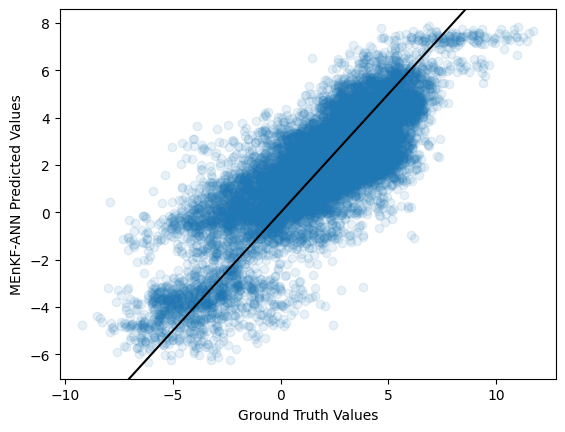

In [63]:
plt.scatter(y_test, averaged_preds_test, alpha = 0.1)
plt.axline((0,0), slope = 1, c = "black")
plt.xlabel("Ground Truth Values")
plt.ylabel("MEnKF-ANN Predicted Values")
# plt.xticks(fontsize = 10, fontweight = "bold")
# plt.yticks(fontsize = 10, fontweight = "bold")
plt.show()

In [64]:
items = [best_train_width, best_coverage_train, best_rmse_train, best_test_width, best_coverage_test, best_rmse_test, best_pearson_r, best_w1_weight, 
        best_w2_weight]

In [65]:
items_df = pd.DataFrame(items).T

In [66]:
items_df.columns = ['best_train_width', 'best_coverage_train', 'best_rmse_train', 'best_test_width', 'best_coverage_test', 'best_rmse_test', 'best_pearson_r', 
                   'best_w1_weight', 'best_w2_weight']

In [67]:
items_df = items_df.T

In [68]:
items_df.columns = ["Value"]

In [69]:
items_df

,Value
best_train_width,5.335477
best_coverage_train,0.863395
best_rmse_train,1.650703
best_test_width,5.323048
best_coverage_test,0.864403
best_rmse_test,1.615585
best_pearson_r,0.821172
best_w1_weight,0.523658
best_w2_weight,0.476342


In [70]:
preds_test.shape

(106, 17316)

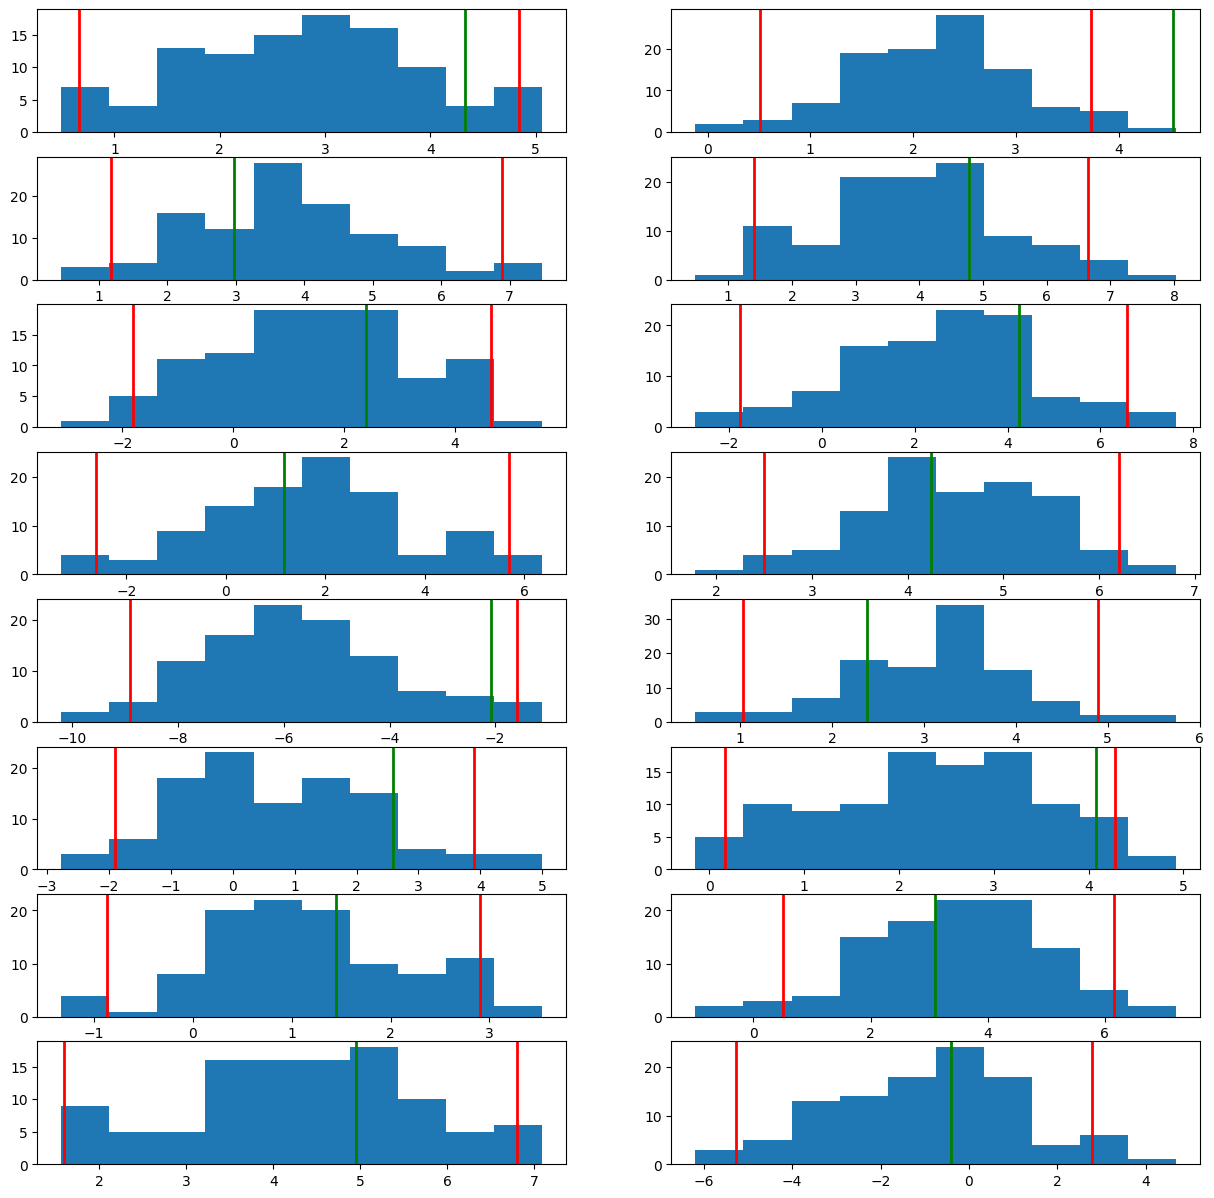

In [71]:
random_idx = random.sample(range(y_test.shape[0]), k = 16)
fig, axs = plt.subplots(8, 2,figsize=(15, 15))
axs = axs.ravel()
for idx, i in enumerate(random_idx):
    # print(counter)
    truth = y_test[i,:]
    preds = preds_test[:, i]
    percts = np.percentile(preds, axis = 0, q = (2.5, 97.5))
    lis = percts[0]
    uis = percts[1]
    
    
    axs[idx].hist(preds)
    axs[idx].axvline(truth, color='green', linewidth=2)
    axs[idx].axvline(lis, color='red', linewidth=2)
    axs[idx].axvline(uis, color='red', linewidth=2)

# plt.title
fig.savefig('gcn_cdr_pred_intervals.png', bbox_inches='tight')
plt.show()


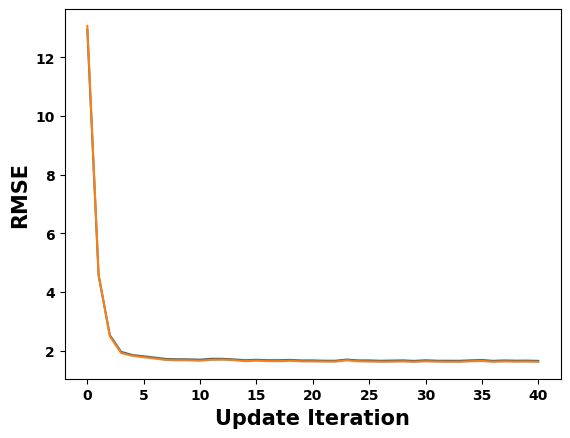

In [72]:
plt.plot(train_rmse)
plt.plot(test_rmse)
plt.xlabel("Update Iteration", fontsize = 15, fontweight = "bold")
plt.ylabel("RMSE", fontsize = 15, fontweight = "bold")
plt.xticks( fontsize = 10, fontweight = "bold")
plt.yticks( fontsize = 10, fontweight = "bold")
plt.show()

In [73]:
# plt.hist(y_train)
# plt.show()

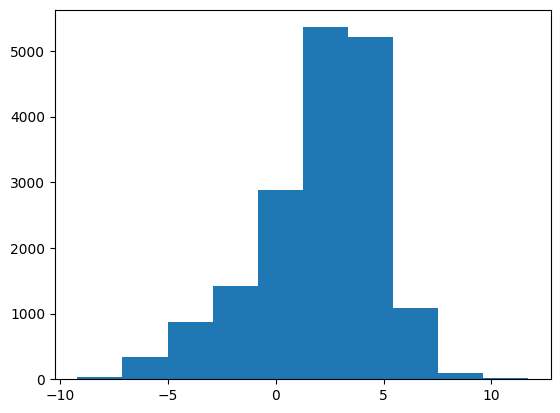

In [74]:
plt.hist(y_test)
plt.show()

In [75]:
catch = Parallel(n_jobs = 14, verbose = 8, backend = "loky")(delayed(get_results)(idx, var_weights = 1.0, var_weight_weights = 1.0, var_D = 1, inflation_factor =1, fudging_beta = beta(1,19), 
           fudging_var = 1*1e-2, print_true = False) for idx in range(0,50))

[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.


test_coverage0.9223839223839224
test_width7.044565942463551
rmse_test1.6410499383477135
weights
[0.23831350851028493, 0.7616864914897152]


test_coverage0.8028413028413028
test_width4.613108010090747
rmse_test1.6149037424533477
weights
[0.8796553991755901, 0.12034460082440994]


test_coverage0.9446176946176946
test_width7.644499838327372
rmse_test1.6183802137097394
weights
[0.63067205506518, 0.36932794493482013]


test_coverage0.6962924462924462
test_width3.5446773477952065
rmse_test1.6088411975242036
weights
[0.9368376333254611, 0.06316236667453863]


test_coverage0.8805151305151305
test_width5.495976919026078
rmse_test1.6222796172603806
weights
[0.5399862211298834, 0.46001377887011663]


test_coverage0.7128089628089628
test_width3.4465144451776832
rmse_test1.613811829164211
weights
[0.880402436392195, 0.1195975636078051]


test_coverage0.7978170478170478
test_width4.348761246495014
rmse_test1.6145099531954075
weights
[0.9273843074748774, 0.07261569252512255]


test_coverage0.75918225

[Parallel(n_jobs=14)]: Done  13 tasks      | elapsed: 34.4min


test_coverage0.9005544005544005
test_width6.030887665361182
rmse_test1.63442101546272
weights
[0.395141421690948, 0.6048585783090521]


test_coverage0.8138138138138138
test_width4.845741119879084
rmse_test1.609947809767337
weights
[0.8963230765868802, 0.10367692341311986]


test_coverage0.9512012012012012
test_width7.794884050181127
rmse_test1.6856162285183376
weights
[0.10233653541840228, 0.8976634645815977]


test_coverage0.7765072765072765
test_width4.485062571325298
rmse_test1.612849414300725
weights
[0.9740265447770157, 0.025973455222984363]


test_coverage0.7228574728574728
test_width3.750025696611676
rmse_test1.6199001149146968
weights
[0.8851861434658731, 0.11481385653412693]


test_coverage0.7484407484407485
test_width3.92993272627773
rmse_test1.6150253214427597
weights
[0.9220733608684728, 0.07792663913152714]


test_coverage0.9868329868329868
test_width11.243384666717386
rmse_test1.6308013057341642
weights
[0.11951912468539427, 0.8804808753146058]


test_coverage0.7493647493

[Parallel(n_jobs=14)]: Done  30 out of  50 | elapsed: 68.1min remaining: 45.4min


test_coverage0.9861399861399861
test_width10.984243857326911
rmse_test1.6577565669500145
weights
[0.160331646224794, 0.8396683537752059]


test_coverage0.9981519981519982
test_width15.660941502060371
rmse_test1.635741692442333
weights
[0.03291398791683189, 0.9670860120831681]


test_coverage0.7130977130977131
test_width3.5768867450341912
rmse_test1.6136049346738088
weights
[0.9664506597880671, 0.03354934021193298]


test_coverage0.9991337491337491
test_width27.44861433272909
rmse_test1.866685074451859
weights
[0.043392247992680676, 0.9566077520073192]


test_coverage0.7346962346962347
test_width3.828130789745096
rmse_test1.6073710447447405
weights
[0.9592245248914533, 0.04077547510854658]


test_coverage0.9777084777084777
test_width10.484303966497762
rmse_test1.6680766686601058
weights
[0.1498120031556933, 0.8501879968443067]


test_coverage0.8727188727188727
test_width5.291931324028488
rmse_test1.6262597126920268
weights
[0.5112450825984681, 0.48875491740153176]




[Parallel(n_jobs=14)]: Done  37 out of  50 | elapsed: 74.6min remaining: 26.2min


test_coverage0.9419034419034419
test_width8.081551926822668
rmse_test1.6286531253550436
weights
[0.32289130455370624, 0.6771086954462937]


test_coverage0.7571032571032571
test_width3.9277815275076753
rmse_test1.6123737820345936
weights
[0.9742577923943787, 0.025742207605621494]


test_coverage0.7446869946869947
test_width3.887467947821117
rmse_test1.611834909358321
weights
[0.8066345915327288, 0.19336540846727127]


test_coverage0.7330214830214831
test_width3.789684435791693
rmse_test1.609951077324835
weights
[0.8256597477261953, 0.17434025227380456]


test_coverage0.9763802263802264
test_width9.956242247830566
rmse_test1.6275844301972788
weights
[0.12897345842818628, 0.8710265415718136]


test_coverage0.7508085008085008
test_width3.8536180177378294
rmse_test1.6136324955800816
weights
[0.7433364762263968, 0.25666352377360335]


test_coverage0.8056133056133056
test_width4.702699053374993
rmse_test1.609758295371787
weights
[0.9802501207423654, 0.019749879257634734]




[Parallel(n_jobs=14)]: Done  44 out of  50 | elapsed: 93.1min remaining: 12.7min


test_coverage0.9202471702471703
test_width6.512930774437243
rmse_test1.6101493037300705
weights
[0.4442400726823517, 0.5557599273176483]


test_coverage0.9183414183414184
test_width6.492677295478992
rmse_test1.6158688250165223
weights
[0.3321727010708824, 0.6678272989291176]


test_coverage0.767960267960268
test_width4.3376365735459075
rmse_test1.6157109400941057
weights
[0.9746050602679889, 0.025394939732011162]


test_coverage0.7557172557172557
test_width4.058056219415491
rmse_test1.6095394775003922
weights
[0.9140280913251626, 0.08597190867483738]


test_coverage0.7505197505197505
test_width3.947557728070913
rmse_test1.6062960173943368
weights
[0.9515993257672284, 0.048400674232771765]


test_coverage0.8235735735735735
test_width5.094752987443049
rmse_test1.613389475408613
weights
[0.9506544659012596, 0.04934553409874045]




[Parallel(n_jobs=14)]: Done  50 out of  50 | elapsed: 106.9min finished


In [76]:
with open("..//Data//DualGCN_run_plots_from_jupyter_all_data.pickle", "wb") as f: 
    pickle.dump(catch, f)

In [77]:
with open("..//Data//DualGCN_run_plots_from_jupyter_all_data.pickle", "rb") as f: 
    catch = pickle.load(f)

In [78]:
all_metrics = []
all_weights = []
for i in range(0,50):
    item = catch[i]
    metrics = item[:7]
    weights = item[-8:-6]
    all_metrics.append(metrics)
    all_weights.append(weights)
    

In [79]:
all_metrics_df = pd.DataFrame(all_metrics)

In [80]:
all_weights_df = pd.DataFrame(all_weights)

In [81]:
all_df = pd.concat([all_metrics_df, all_weights_df], axis = 1)

In [82]:
all_df.columns = ['train_width', 'coverage_train', 'rmse_train', 'test_width', 'coverage_test', 'rmse_test', 'pearson_r', 
                   "DualGCN_Drugs", "DualGCN_Omics"]

In [83]:
all_df.mean()

train_width       6.415213
coverage_train    0.835360
rmse_train        1.660553
test_width        6.394910
coverage_test     0.837205
rmse_test         1.626663
pearson_r         0.818590
DualGCN_Drugs     0.642012
DualGCN_Omics     0.357988
dtype: float64

In [84]:
all_df.std()

train_width       4.203757
coverage_train    0.101645
rmse_train        0.038865
test_width        4.213785
coverage_test     0.102410
rmse_test         0.038465
pearson_r         0.010311
DualGCN_Drugs     0.345091
DualGCN_Omics     0.345091
dtype: float64

In [85]:
with open("..//Data//DualGCN_run_plot_from_jupyter_test_features_and_ground_truth_all_data.pickle", "wb") as f: 
    pickle.dump(current_test, f)

In [86]:
add_preds = np.zeros((y_test.shape[0], y_test.shape[1]))
for item in catch: 
    preds = item[-4]
    add_preds+= preds

In [87]:
averaged_preds = add_preds/50

In [88]:
from sklearn.metrics import mean_squared_error

In [89]:
mse = mean_squared_error(y_test, averaged_preds)

In [90]:
np.sqrt(mse)

1.6012817212328836

In [91]:
from scipy.stats import pearsonr

In [92]:
pearsonr_test = pearsonr(y_test.reshape(y_test.shape[0],), 
                                 averaged_preds.reshape(averaged_preds.shape[0],))

In [93]:
pearsonr_test.statistic

0.8247479944555509

In [94]:
all_li = np.zeros((y_test.shape[0], len(catch)))
all_ui = np.zeros((y_test.shape[0], len(catch)))
for i, item in enumerate(catch): 
    preds = item[-3:-1]
    all_li[:,i] =  preds[0][:,0]
    all_ui[:,i] =  preds[1][:,0]

In [95]:
li = np.median(all_li, axis = 1).reshape(-1,1)

In [96]:
li_mean = np.mean(all_li, axis = 1).reshape(-1,1)

In [97]:
ui = np.median(all_ui, axis = 1).reshape(-1,1)

In [98]:
ui_mean = np.mean(all_ui, axis = 1).reshape(-1,1)

In [99]:
combo = np.hstack((y_test, li, ui))

In [100]:
combo_mean = np.hstack((y_test, li_mean, ui_mean))

In [101]:
combo_mean_df = pd.DataFrame(combo_mean)

In [102]:
combo_mean_df.columns = ["IC50", "LI_IC50_Pred", "UI_IC50_Pred"]

In [103]:
combo_mean_df["coverage"] = (combo_mean_df["IC50"] >= combo_mean_df["LI_IC50_Pred"]) & (combo_mean_df["IC50"] <= combo_mean_df["UI_IC50_Pred"])

In [104]:
combo_mean_df["coverage"].mean()

0.9348001848001848

In [105]:
combo_mean_df["width"] = combo_mean_df["UI_IC50_Pred"]-combo_mean_df["LI_IC50_Pred"]

In [106]:
combo_mean_df["width"].mean()

6.394910015236429

In [107]:
combo_df = pd.DataFrame(combo)

In [108]:
combo_df.columns = ["IC50", "LI_IC50_Pred", "UI_IC50_Pred"]

In [109]:
combo_df = combo_df.sort_values("IC50").reset_index(drop = True)

In [110]:
combo_df["coverage"] = (combo_df["IC50"] >= combo_df["LI_IC50_Pred"]) & (combo_df["IC50"] <= combo_df["UI_IC50_Pred"])

In [111]:
combo_df["coverage"].mean()

0.8490990990990991

In [112]:
combo_df["width"] = combo_df["UI_IC50_Pred"]-combo_df["LI_IC50_Pred"]

In [113]:
combo_df["width"].mean()

4.746868769915126